# Table of Contents
 <p><div class="lev2 toc-item"><a href="#Determining-best-n_neighbor-parameter" data-toc-modified-id="Determining-best-n_neighbor-parameter-01"><span class="toc-item-num">0.1&nbsp;&nbsp;</span>Determining best n_neighbor parameter</a></div><div class="lev2 toc-item"><a href="#Comparing-Algorithms" data-toc-modified-id="Comparing-Algorithms-02"><span class="toc-item-num">0.2&nbsp;&nbsp;</span>Comparing Algorithms</a></div><div class="lev2 toc-item"><a href="#Learning-Curve-for-Knn-and-LDA-(logarithmic-scale)" data-toc-modified-id="Learning-Curve-for-Knn-and-LDA-(logarithmic-scale)-03"><span class="toc-item-num">0.3&nbsp;&nbsp;</span>Learning Curve for Knn and LDA (logarithmic scale)</a></div>

In [2]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import learning_curve
import math


hali_data = pd.read_csv('hali-class-data.csv')

# Balance the data 
hali_data_cancer = hali_data.loc[hali_data['class']== 'Cancer']
hali_data_noncancer = hali_data.loc[hali_data['class']== 'Non-Cancer']
hali_data_noncancer = hali_data_noncancer.sample(len(hali_data_cancer)) #random sample of size of cancer data.
hali_data_balanced = hali_data_cancer.append(hali_data_noncancer)
hali_data_balanced = hali_data_balanced.sample(frac = 1) #Randomly mix up data
hali_data = hali_data_balanced

X = hali_data[list(hali_data)[:-1]].values
y = hali_data['class'].values

## Determining best n_neighbor parameter

The following was run on lauterbur:

In [ ]:
kNeighbours = [1, 10, 101, 1001, 10001] 

estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('knn', KNeighborsClassifier()))
model = Pipeline(estimators)
parameter_grid = {'knn__n_neighbors' : kNeighbours}
grid_search = GridSearchCV(model, param_grid=parameter_grid, n_jobs=4)

grid_search.fit(X, y)

In [6]:
# Read in results

knn_result = pd.read_csv('knnResultsBalanced.csv')
results = knn_result.iloc[0:5,:]
results

,n_neighbor,accuracy
0,1,0.738520
1,11,0.797597
2,101,0.804391
3,1001,0.800720
4,10001,0.784861


The growth slows down dramatically from 11 to 101 and begins to decline from 101 to 10001. Next, the grid search is run again with neighbours from 1 to 601. The results returned are plotted on a log scale, and show that the best neighbors parameter is 201, but not much loss in either direction.

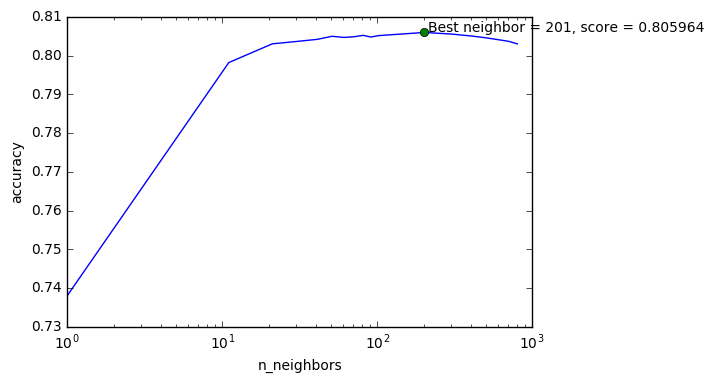

In [7]:
X = knn_result.iloc[5:-1,0].values
Y = knn_result.iloc[5:-1,1].values

plt.plot(X, Y)
plt.xlabel('n_neighbors')
plt.ylabel('accuracy')
plt.xscale('log')
max_y = max(Y)  # Find the maximum y value
max_x = X[Y.argmax()]  # Find the x value corresponding to the maximum y value
plt.plot([max_x], [max_y], 'o')
plt.annotate('Best neighbor = %d, score = %f'%(max_x, max_y), xy=(max_x, max_y), xytext=(max_x+10, max_y+(0.0001*max_y)))

## Comparing Algorithms

KNN: 0.806172 (0.002306)
LDA: 0.786901 (0.002052)
QDA: 0.775069 (0.003255)
NB: 0.775011 (0.003225)


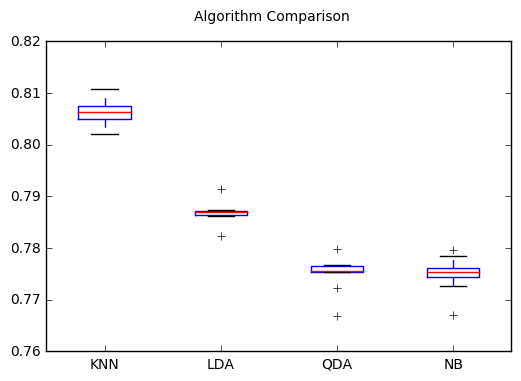

In [8]:
results = []
names = []
models = []

# Knn model
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('knn', KNeighborsClassifier(n_neighbors=201, n_jobs=-1)))
models.append(('KNN', Pipeline(estimators)))

# LDA Model
models.append(('LDA', LinearDiscriminantAnalysis()))

# QDA Model
models.append(('QDA', QuadraticDiscriminantAnalysis()))

# NB Model
models.append(('NB', GaussianNB()))

X = hali_data[list(hali_data)[:-1]].values
y = hali_data['class'].values

for name, model in models:
    cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
    cv_results = cross_val_score(model, X, y, cv=cv)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
    
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

## Learning Curve for Knn and LDA (logarithmic scale)

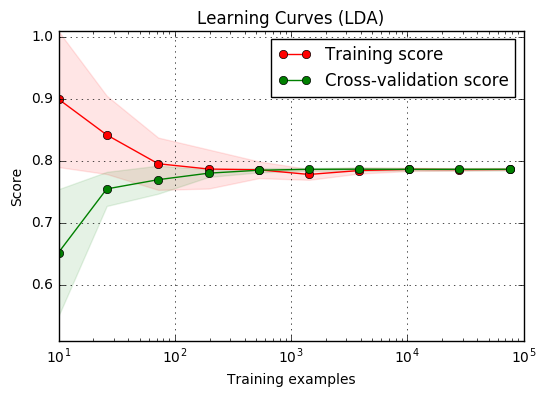

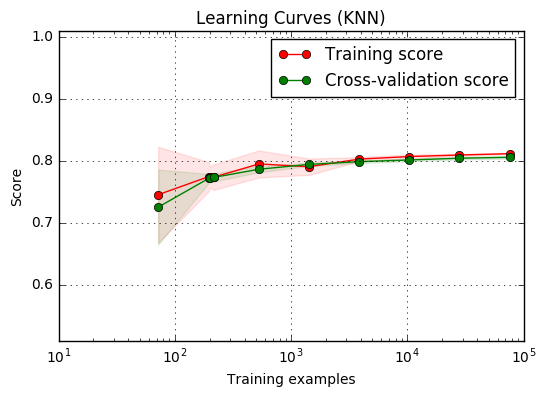

In [9]:
X = hali_data[list(hali_data)[:-1]].values
y = hali_data['class'].values

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.logspace(1, math.log10(len(X)*.8), num=10).astype(int)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    plt.xscale('log')
    return plt


cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

# Logarithmic scale
train_space = np.logspace(1, math.log10(len(X)*.8), num=10).astype(int)

title = "Learning Curves (LDA)"
estimator = LinearDiscriminantAnalysis()
plot_learning_curve(estimator, title, X, y, (.51, 1.01), cv=cv, n_jobs=1)

title = "Learning Curves (KNN)"
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('knn', KNeighborsClassifier(n_neighbors=51, n_jobs=1)))
estimator = Pipeline(estimators)
# for KNN training size must be greater than n_neighbors
train_space[0] = train_space[0] + 191
train_space[1] = train_space[1] + 191
plot_learning_curve(estimator, title, X, y, (.51, 1.01), cv=cv, n_jobs=1, train_sizes = train_space)

plt.show()